# Forecasting multiple independent time series

[Forecasting for machine learning](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook we will show how to forecast multiple **independent** time series using a **local** and **global** forecasting approach with **traditional machine learning models**. We will use the `skforecast` package to help us do this.

This notebook is adapted from the [skforecast example notebook](https://cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html).


## Data set synopsis

Data has been obtained from [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data), specifically `train.csv`. This dataset contains 913,000 sales transactions from 2013–01–01 to 2017–12–31 for 50 products (SKU) in 10 stores. The goal is to predict the next 7 days sales for 50 different items in one store using the available 5 years history.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data

In [2]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


`ForecasterAutoregMultiSeries` and `ForecasterAutoregMultiSeriesCustom` requires that each time series is a column in the dataframe and that the index is time-like (datetime or timestamp). 

So now we process the data to get dataframes in the required format.

In [3]:
# Data preprocessing

selected_store = 2
selected_items = data["item"].unique()  # All items
# selected_items = [1, 2, 3, 4, 5] # Selection of items to reduce computation time

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

data.head()

,date,store,item,sales
1826,2013-01-01,2,1,12
1827,2013-01-02,2,1,16
1828,2013-01-03,2,1,16
1829,2013-01-04,2,1,20
1830,2013-01-05,2,1,16


In [4]:
# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")

data.head()

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,11.0,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,19.0,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,23.0,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,15.0,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0
2013-01-05,16.0,44.0,25.0,14.0,9.0,47.0,55.0,64.0,45.0,53.0,...,19.0,39.0,41.0,19.0,78.0,41.0,18.0,53.0,20.0,55.0


In [5]:
# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data.head()

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,11.0,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,19.0,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,23.0,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,15.0,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0
2013-01-05,16.0,44.0,25.0,14.0,9.0,47.0,55.0,64.0,45.0,53.0,...,19.0,39.0,41.0,19.0,78.0,41.0,18.0,53.0,20.0,55.0


In [6]:
# Check if any missing values introduced
data.isnull().sum().any()

False

Four of the series are plotted to understand their trends and patterns. The reader is strongly encouraged to plot several more to gain an in-depth understanding of the series.



/var/folders/lf/8j5fhbgs6w91njx87pb8mk2w0000gq/T/ipykernel_89009/1227022470.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


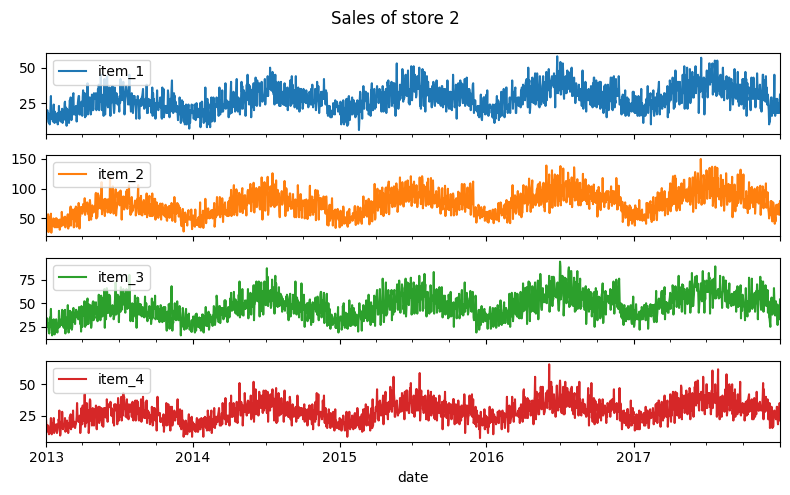

In [7]:
# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)
fig.tight_layout()

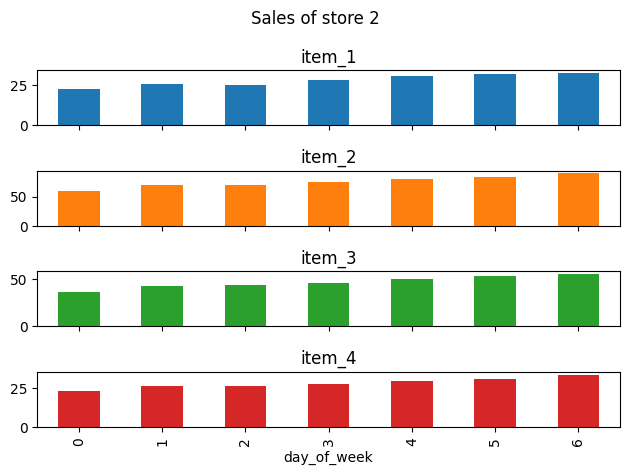

In [8]:
# Quick and dirty plot to check for weekly seasonality
(
    data.assign(day_of_week=lambda x: data.index.weekday).groupby("day_of_week").mean()
).iloc[:, :4].plot(
    legend=False,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    kind="bar",
)
plt.tight_layout()

Let's add the day of the week to use as an exogenous feature.

In [9]:
data["day_of_week"] = data.index.weekday

# Linear models would better capture seasonality using fourier or cyclical features.
# Read more about them here:
# https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.fourier.FourierFeatures.html
# https://feature-engine.trainindata.com/en/latest/user_guide/creation/CyclicalFeatures.html#cyclical-features

In [10]:
data

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0,1
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0,2
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0,3
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0,4
2013-01-05,16.0,44.0,25.0,14.0,9.0,47.0,55.0,64.0,45.0,53.0,...,39.0,41.0,19.0,78.0,41.0,18.0,53.0,20.0,55.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0,74.0,36.0,26.0,20.0,56.0,65.0,79.0,51.0,63.0,...,33.0,45.0,31.0,99.0,59.0,22.0,48.0,30.0,79.0,2
2017-12-28,21.0,69.0,40.0,23.0,18.0,63.0,73.0,91.0,60.0,78.0,...,46.0,64.0,31.0,99.0,64.0,24.0,37.0,31.0,68.0,3
2017-12-29,18.0,56.0,33.0,21.0,25.0,72.0,69.0,99.0,48.0,76.0,...,56.0,59.0,37.0,91.0,78.0,33.0,56.0,33.0,67.0,4


# Local forecasting approach: Training one model per time series

A different model is trained for each item of the store.

In [11]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Forecasters from skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom

In [12]:
# Define a function to extract lag and window features
# See: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/custom-predictors.html
def create_predictors(y):
    """
    Create first 7 lags of a time series.
    Calculate rolling mean and standard deviation with window 7 and 30.
    """

    lags = y[-1:-8:-1]  # window_size = 8
    mean_7 = np.mean(y[-7:])  # window_size = 7
    std_7 = np.std(y[-7:])
    mean_30 = np.mean(y[-30:])  # window_size = 30
    std_30 = np.std(y[-30:])

    predictors = np.hstack([lags, mean_7, std_7, mean_30, std_30])

    return predictors


name_predictors = [f"lag_{i}" for i in range(1, 8)] + [
    "mean_7",
    "std_7",
    "mean_30",
    "std_30",
]
name_predictors

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'mean_7',
 'std_7',
 'mean_30',
 'std_30']

In [13]:
# Create forecaster
forecaster = ForecasterAutoregCustom(
    regressor=Ridge(alpha=1),
    fun_predictors=create_predictors,
    name_predictors=name_predictors,
    window_size=30,  # Largest window size needed
    # by `create_predictors`
    transformer_y=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# REFERENCE: To create forecaster with only lag features and no window features
# forecaster = ForecasterAutoreg(
#                  regressor        = Ridge(alpha=1),
#                  lags             = 7
#                  transformer_y    = StandardScaler(),
#                  transformer_exog = StandardScaler(),
#              )

In [14]:
# Check the feature matrix and target variable
# created by the `forecaster` object.
time_series_1 = data["item_1"]
X_train, y_train = forecaster.create_train_X_y(y=time_series_1)
display(X_train.head(), y_train.head())

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,mean_7,std_7,mean_30,std_30
date,,,,,,,,,,,
2013-01-31,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.287484,-1.633160,-1.600239,0.293538,-1.441118,0.492768
2013-02-01,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.287484,-1.567317,0.300832,-1.425755,0.486501
2013-02-02,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.583778,0.287946,-1.425755,0.486501
2013-02-03,-0.596131,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.435631,0.447176,-1.398869,0.508807
2013-02-04,-1.633160,-0.596131,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.402709,0.422244,-1.421914,0.503210


date
2013-01-31   -1.402709
2013-02-01   -1.402709
2013-02-02   -0.596131
2013-02-03   -1.633160
2013-02-04   -1.172258
Freq: D, Name: y, dtype: float64

In [15]:
# Target time series column names
target_cols = data.filter(like="item_").columns

# Exogenous feature column names
exog_cols = ["day_of_week"]

# Forecast horizon: Number of steps to predict
steps = 14

In [16]:
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=steps)

In [17]:
# Prepare exogenous features for the future
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=steps)

future_exog = pd.DataFrame(index=future_dates)
future_exog["day_of_week"] = future_exog.index.weekday

In [18]:
# Prepare containers to store predictions
models = {}
predictions = {}

# Train a model and make a forecast for each time series
for item in target_cols:

    # Create forecaster
    forecaster = ForecasterAutoregCustom(
        regressor=Ridge(alpha=1),
        fun_predictors=create_predictors,
        name_predictors=name_predictors,
        window_size=30,  # Largest window size needed
        # by `create_predictors`
        transformer_y=StandardScaler(),
        transformer_exog=StandardScaler(),
    )

    # Fit model
    forecaster.fit(y=data[item], exog=data[exog_cols])

    y_pred = forecaster.predict(steps=14, exog=future_exog)

    models[item] = forecaster
    predictions[item] = y_pred

# Results
forecast = pd.DataFrame(predictions)
forecast

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2018-01-01,17.833356,53.183684,31.113886,20.771849,16.002714,49.266085,51.676762,72.905060,41.280327,59.362680,...,17.859651,33.901508,45.866801,25.311185,75.397233,52.152715,20.429296,41.838427,25.899963,54.489110
2018-01-02,19.408108,58.767439,35.459965,22.303675,17.000823,52.281538,56.046074,82.180036,48.493694,67.838831,...,19.662989,37.053732,50.221859,26.973407,86.030739,57.846313,21.537318,44.980672,29.401709,58.427479
2018-01-03,20.250197,62.116510,36.202255,23.610807,18.496017,55.876898,59.879512,84.013630,50.597485,71.037731,...,21.812239,39.382888,52.871310,28.423078,89.940762,61.119735,22.526646,47.981539,29.983282,64.386066
2018-01-04,22.199956,65.656430,38.807197,25.055290,19.874896,60.597656,63.638146,91.795506,55.120503,76.255754,...,23.650974,42.595524,58.017052,30.551502,93.654494,66.277658,24.261181,51.712318,32.265738,67.930684
2018-01-05,24.560595,68.208273,41.958544,26.331003,21.806399,65.710026,67.939503,97.845411,58.668142,82.976581,...,25.750225,46.262606,61.686129,33.190000,99.151309,72.233005,26.424569,58.177852,34.713521,72.759315
2018-01-06,26.858109,74.673463,46.572891,29.196557,23.412518,69.741029,73.342076,104.243654,63.425212,88.003101,...,27.107218,48.380868,67.077273,36.020133,107.935570,75.443719,28.142728,62.643172,37.656981,79.379567
2018-01-07,28.468277,80.289253,50.851067,30.906827,25.477129,74.782839,78.678488,113.748859,69.191292,98.961641,...,29.755263,52.161477,72.373485,39.140611,116.236776,81.011864,30.465426,66.834913,41.298829,85.507527
2018-01-08,18.410763,51.984585,32.397828,21.078709,15.503852,48.983899,51.270814,74.696751,43.227005,60.496903,...,19.247661,34.144615,46.999239,25.289220,76.587201,53.622993,20.385587,42.998846,26.372958,55.384931
2018-01-09,20.040477,58.030612,35.763138,22.846514,17.471618,54.344694,56.650095,82.088468,49.515631,68.145167,...,21.222952,37.072654,51.994287,28.417008,85.311125,59.768838,21.996381,47.571971,29.124669,61.557267
2018-01-10,21.242148,61.291239,37.709027,24.126242,18.645837,57.401677,60.171715,84.951390,51.882631,72.089295,...,22.758280,39.082170,55.354044,30.232838,89.672248,62.057520,23.492396,50.414105,30.686878,65.482203


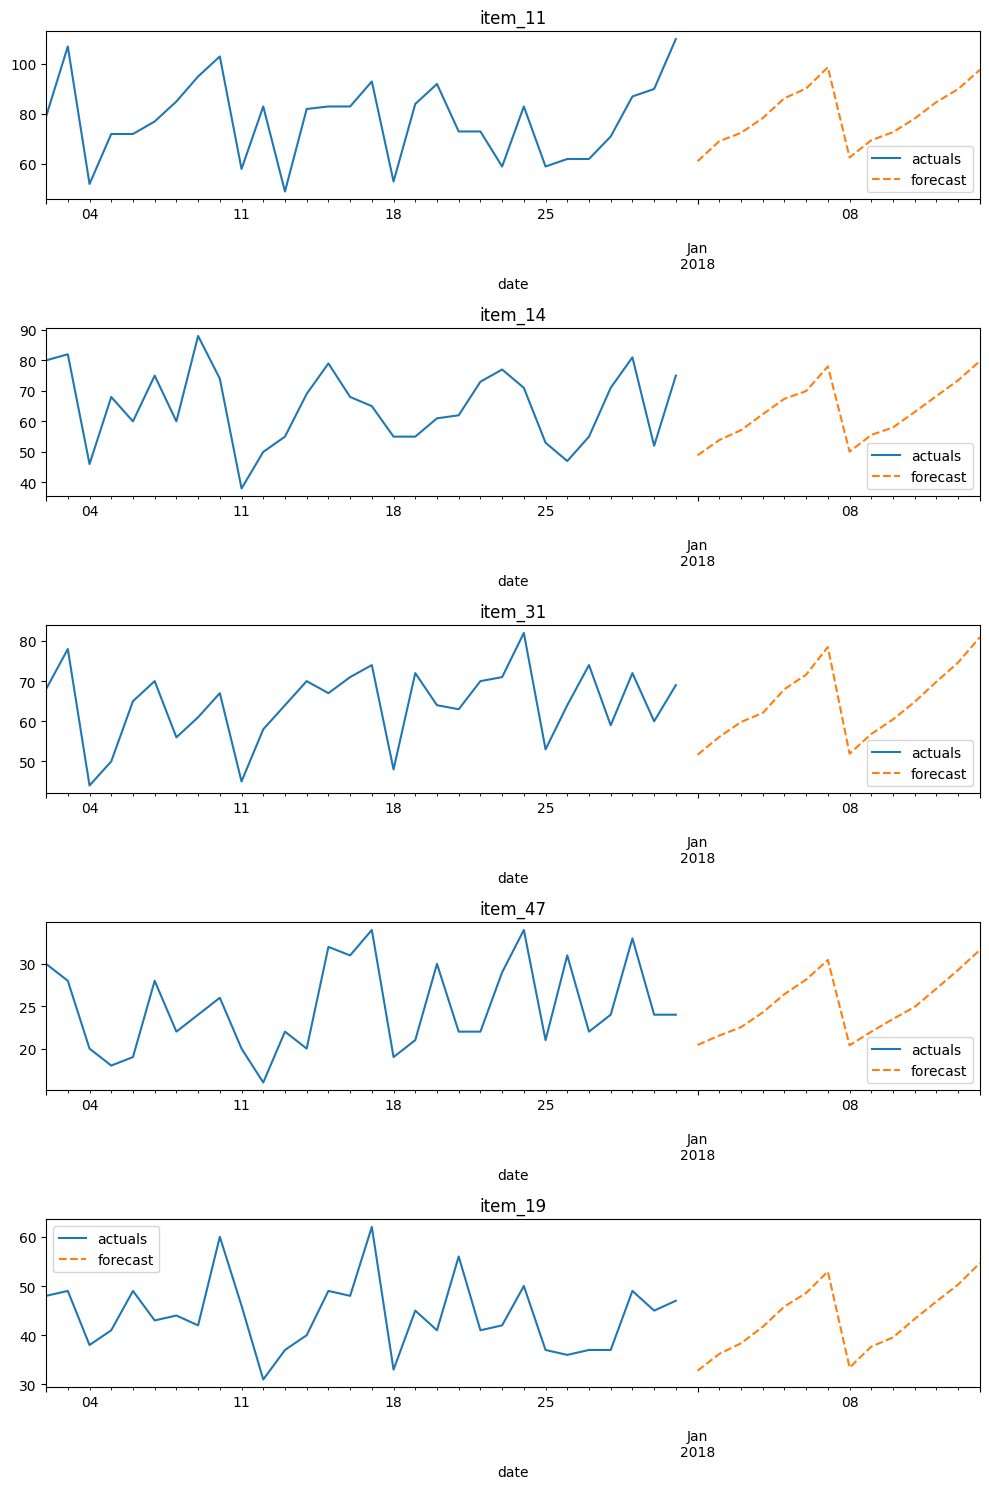

In [19]:
# Plot forecast

# Select a random subsample of timeseries
num_timeseries = 5
data_subset = data[target_cols].sample(n=num_timeseries, axis=1, random_state=123)

# Plotting
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for ix in range(num_timeseries):
    item = data_subset.columns[ix]
    ax = axs[ix]

    data_subset.iloc[-30:][item].plot(ax=ax, label="actuals")
    forecast.loc[:, item].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{item}")

plt.tight_layout()

In [20]:
models["item_1"].get_feature_importances()

,feature,importance
0,lag_1,0.065197
1,lag_2,0.108936
2,lag_3,0.056575
3,lag_4,0.053778
4,lag_5,0.069797
5,lag_6,0.085235
6,lag_7,0.029642
7,mean_7,0.067023
8,std_7,0.052782
9,mean_30,0.387761


## Global forecasting approach: Training one model for all time series

In [21]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Forecasters from skforecast (recursive)
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiSeriesCustom import (
    ForecasterAutoregMultiSeriesCustom,
)

In [22]:
# Define a function to extract lag and window features
# See: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/custom-predictors.html
def create_predictors(y):
    """
    Create first 7 lags of a time series.
    Calculate rolling mean and standard deviation with window 7 and 30.
    """

    lags = y[-1:-8:-1]  # window_size = 8
    mean_7 = np.mean(y[-7:])  # window_size = 7
    std_7 = np.std(y[-7:])
    mean_30 = np.mean(y[-30:])  # window_size = 30
    std_30 = np.std(y[-30:])

    predictors = np.hstack([lags, mean_7, std_7, mean_30, std_30])

    return predictors


name_predictors = [f"lag_{i}" for i in range(1, 8)] + [
    "mean_7",
    "std_7",
    "mean_30",
    "std_30",
]
name_predictors

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'mean_7',
 'std_7',
 'mean_30',
 'std_30']

In [23]:
# Create and fit a forecaster

# Create forecaster
forecaster = ForecasterAutoregMultiSeriesCustom(
    regressor=Ridge(alpha=1),
    fun_predictors=create_predictors,
    name_predictors=name_predictors,
    window_size=30,  # Largest window size needed
    # by `create_predictors`
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# REFERENCE: To create forecaster with only lag features and no window features
# forecaster = ForecasterAutoregMultiSeries(
#                  regressor        = Ridge(alpha=1),
#                  lags             = 7
#                  transformer_series    = StandardScaler(),
#                  transformer_exog = StandardScaler(),
#              )

# Target time series column names
target_cols = data.filter(like="item_").columns

# Exogenous feature column names
exog_cols = ["day_of_week"]

forecaster.fit(
    series=data[target_cols],  # Dataframe of target time series at train time
    exog=data[exog_cols],  # Dataframe of exogenous variables at train time
)

forecaster

ForecasterAutoregMultiSeriesCustom 
Regressor: Ridge(alpha=1) 
Predictors created with function: create_predictors 
Transformer for series: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 30 
Series levels (names): ['item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7', 'item_8', 'item_9', 'item_10', 'item_11', 'item_12', 'item_13', 'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19', 'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25', 'item_26', 'item_27', 'item_28', 'item_29', 'item_30', 'item_31', 'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37', 'item_38', 'item_39', 'item_40', 'item_41', 'item_42', 'item_43', 'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49', 'item_50'] 
Series weights: None 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['day_of_week'] 
Training range: [Timestamp(

In [24]:
data.head()

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0,1
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0,2
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0,3
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0,4
2013-01-05,16.0,44.0,25.0,14.0,9.0,47.0,55.0,64.0,45.0,53.0,...,39.0,41.0,19.0,78.0,41.0,18.0,53.0,20.0,55.0,5


In [25]:
X_train, y_train, y_index, y_train_index = forecaster.create_train_X_y(
    series=data[target_cols], exog=data[exog_cols]
)
display(X_train.columns)
display(X_train.head(), y_train.head())

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'mean_7',
       'std_7', 'mean_30', 'std_30', 'day_of_week', 'item_1', 'item_10',
       'item_11', 'item_12', 'item_13', 'item_14', 'item_15', 'item_16',
       'item_17', 'item_18', 'item_19', 'item_2', 'item_20', 'item_21',
       'item_22', 'item_23', 'item_24', 'item_25', 'item_26', 'item_27',
       'item_28', 'item_29', 'item_3', 'item_30', 'item_31', 'item_32',
       'item_33', 'item_34', 'item_35', 'item_36', 'item_37', 'item_38',
       'item_39', 'item_4', 'item_40', 'item_41', 'item_42', 'item_43',
       'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49',
       'item_5', 'item_50', 'item_6', 'item_7', 'item_8', 'item_9'],
      dtype='object')

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,mean_7,std_7,mean_30,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
0,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.287484,-1.633160,-1.600239,0.293538,-1.441118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.287484,-1.567317,0.300832,-1.425755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.583778,0.287946,-1.425755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.596131,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.435631,0.447176,-1.398869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.633160,-0.596131,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.402709,0.422244,-1.421914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0   -1.402709
1   -1.402709
2   -0.596131
3   -1.633160
4   -1.172258
Name: y, dtype: float64

In [26]:
# Forecast horizon: Number of steps to predict
steps = 14

# Prepare exogenous features for the future
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=steps + 1)

future_exog = pd.DataFrame(index=future_dates)
future_exog["day_of_week"] = future_exog.index.weekday

In [27]:
# Predict

# Forecast for item_1 and item_2
forecast_item_1_2 = forecaster.predict(
    steps=steps, exog=future_exog, levels=["item_1", "item_2"]
)
forecast_item_1_2

,item_1,item_2
2018-01-01,16.079620,53.362497
2018-01-02,18.799400,58.613809
2018-01-03,19.308834,61.428807
2018-01-04,21.386537,64.842036
2018-01-05,23.376029,68.674836
2018-01-06,26.104672,74.967569
2018-01-07,28.776748,80.382667
2018-01-08,16.704842,52.884746
2018-01-09,19.080620,58.233959
2018-01-10,20.298640,61.152855


In [28]:
# Forecast for all items
forecast = forecaster.predict(steps=steps, exog=future_exog, levels=None)
forecast

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2018-01-01,16.079620,53.362497,29.882041,19.583895,16.328581,50.164970,52.468165,73.496929,42.494760,61.393301,...,16.702064,34.109412,46.236492,24.260182,78.612346,52.578962,19.695515,41.971362,25.417942,54.738581
2018-01-02,18.799400,58.613809,35.072248,21.230493,16.951335,53.430920,56.644197,82.451525,48.219319,69.678114,...,18.482156,37.731907,50.570592,26.111326,87.221001,57.775854,21.638811,45.721221,29.257156,59.010597
2018-01-03,19.308834,61.428807,35.507190,22.909191,18.415925,57.020788,60.185571,85.551225,51.021240,72.465345,...,20.206072,39.858370,52.610517,27.847529,90.749782,61.338788,22.179079,48.855520,29.893119,64.208696
2018-01-04,21.386537,64.842036,38.465103,24.402133,19.735401,61.540246,64.564556,92.255518,55.246447,78.558677,...,21.882695,43.399599,57.529079,30.078730,96.215291,66.010304,24.053057,52.341910,32.274642,67.961907
2018-01-05,23.376029,68.674836,41.333342,26.314033,21.944707,66.379608,68.527020,98.776903,58.700438,84.268607,...,24.182410,46.713209,61.041007,32.750021,102.119850,71.370040,26.440099,58.312592,35.108982,73.308484
2018-01-06,26.104672,74.967569,45.171908,29.372519,23.379701,70.746845,73.767798,104.856078,64.038780,90.517527,...,26.523613,49.152050,65.962669,35.048239,110.024440,75.491312,27.781621,62.904917,37.708147,79.853241
2018-01-07,28.776748,80.382667,50.415272,30.998575,25.701358,75.974095,79.186681,112.629040,69.768021,99.305044,...,29.204080,52.807823,70.251098,37.900777,118.311450,81.378660,30.297527,67.706290,41.751679,85.702625
2018-01-08,16.704842,52.884746,31.508268,19.510448,15.555942,50.349371,52.354708,75.508166,44.342897,63.330083,...,17.297410,34.514341,47.097434,24.384567,81.315561,53.887945,19.282951,43.571742,26.163604,56.041054
2018-01-09,19.080620,58.233959,35.313827,21.792049,17.493018,55.839469,57.691371,82.835184,49.394979,70.222190,...,19.600052,38.097522,51.860353,27.253573,88.953145,59.412829,21.520652,48.440883,29.281752,62.087936
2018-01-10,20.298640,61.152855,37.220900,23.095801,18.684616,59.039137,60.777271,86.537357,52.110354,73.685598,...,20.904565,40.087482,54.636886,29.013948,93.256123,62.545701,22.766983,51.277727,30.884902,65.720959


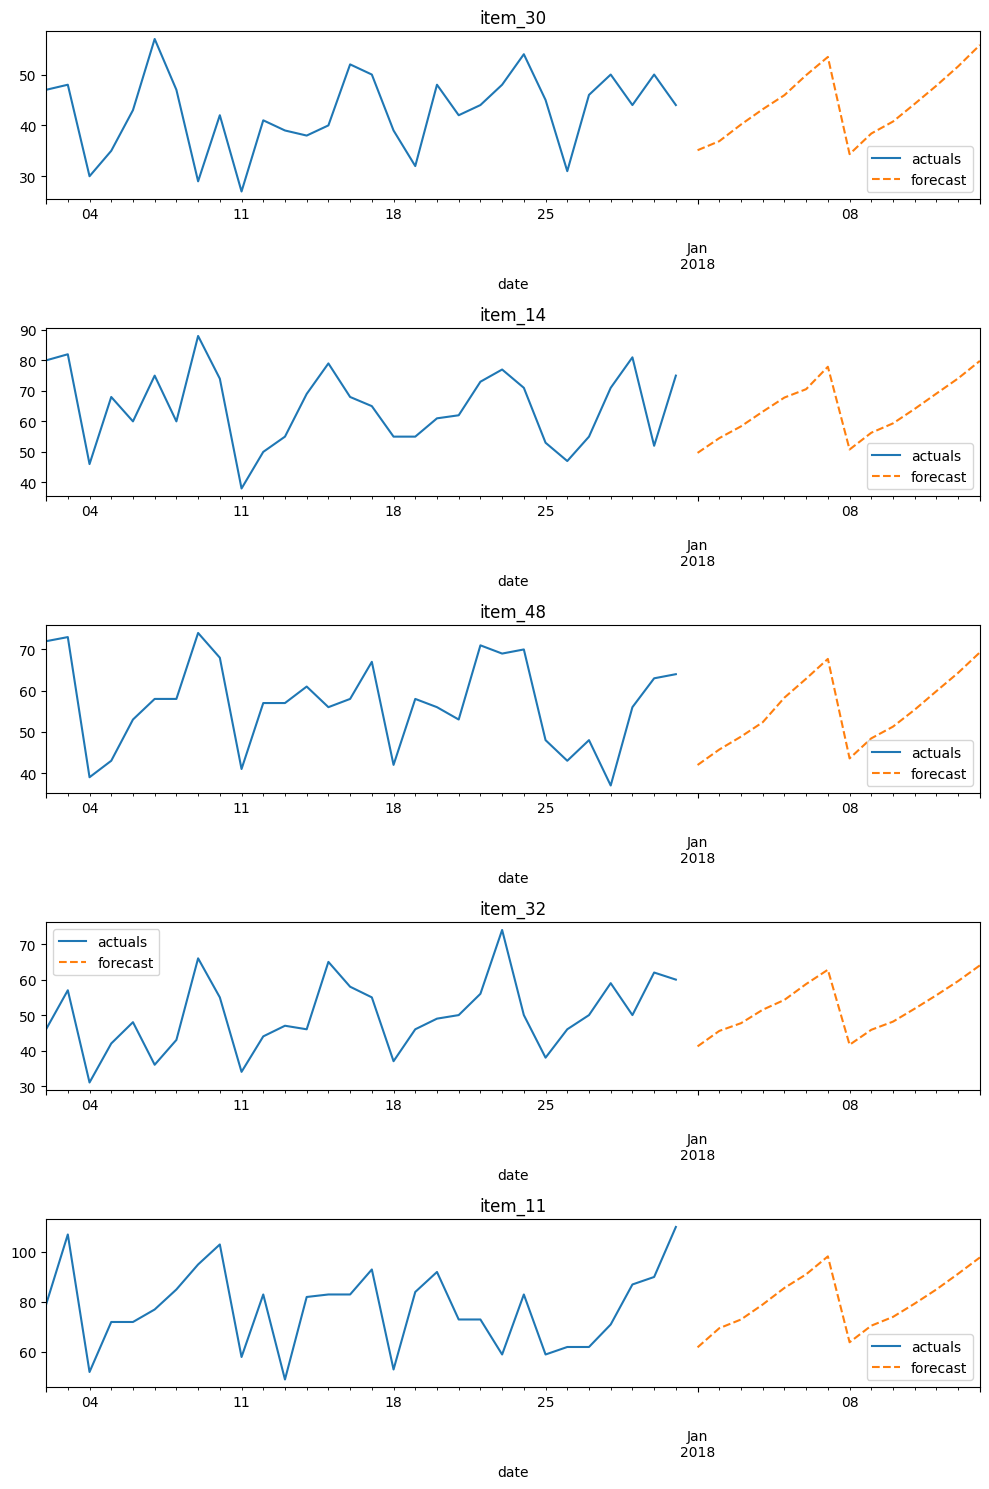

In [29]:
# Plot forecast

# Select a random subsample of timeseries
num_timeseries = 5
data_subset = data.sample(n=num_timeseries, axis=1, random_state=123)

# Plotting
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for ix in range(num_timeseries):
    item = data_subset.columns[ix]
    ax = axs[ix]

    data_subset.iloc[-30:][item].plot(ax=ax, label="actuals")
    forecast.loc[:, item].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{item}")

plt.tight_layout()

In [30]:
# Interval forecasts for item_1 and item_2
# See more details here: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/probabilistic-forecasting.html

forecast_intervals = forecaster.predict_interval(
    steps=steps, exog=future_exog, levels=["item_1", "item_2"]
)
forecast_intervals.head(3)

,item_1,item_1_lower_bound,item_1_upper_bound,item_2,item_2_lower_bound,item_2_upper_bound
2018-01-01,16.079620,6.162293,26.146444,53.362497,37.902194,70.218761
2018-01-02,18.799400,9.531967,29.162440,58.613809,42.889462,76.311374
2018-01-03,19.308834,10.046746,28.856633,61.428807,45.722227,79.482480


## Feature importance

In [31]:
# Feature importance
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.058971
1,lag_2,0.134896
2,lag_3,0.101420
3,lag_4,0.080010
4,lag_5,0.078293
...,...,...
57,item_50,-0.010961
58,item_6,-0.006018
59,item_7,-0.005150
60,item_8,-0.009292


<Axes: xlabel='feature'>

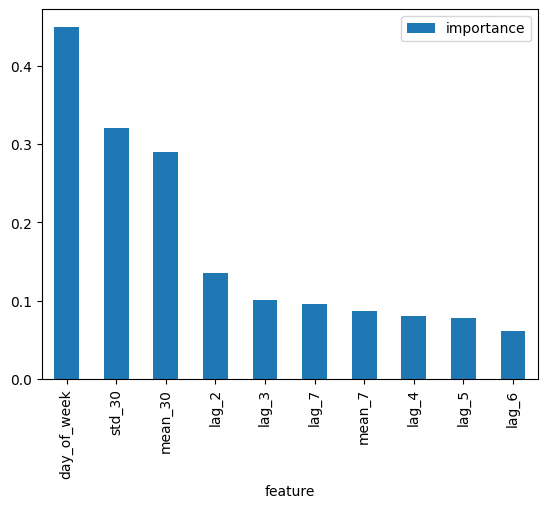

In [32]:
# Plot feature importance
(
    forecaster.get_feature_importances()
    .assign(importance=lambda df: np.abs(df.importance))
    .nlargest(n=10, columns=["importance"])
    .set_index("feature")
).plot(kind="bar")

In [33]:
model = Ridge(alpha=1)

In [34]:
model.fit()

TypeError: Ridge.fit() missing 2 required positional arguments: 'X' and 'y'

## Weights in multi-series

The weights are used to control the influence that each observation has on the training of the model. `ForecasterAutoregMultiseries` accepts two types of weights:

+ `series_weights` controls the relative importance of each series. If a series has twice as much weight as the others, the observations of that series influence the training twice as much. The higher the weight of a series relative to the others, the more the model will focus on trying to learn that series.

+ `weight_func` controls the relative importance of each observation according to its index value. For example, a function that assigns a lower weight to certain dates.

If the two types of weights are indicated, they are **multiplied to create the final weights**. The resulting `sample_weight` cannot have negative values.

<p style="text-align: center">
<img src="./images/forecaster_multi_series_sample_weight.png" style="width: 900px">
<br>
<font size="2.5"> <i>Weights in multi-series.</i></font>
</p>

+ `series_weights` is a dict of the form `{'series_column_name': float}`. If a series is used during `fit` and is not present in `series_weights`, it will have a weight of 1.

+ `weight_func` is a function that defines the individual weights of each sample **based on the index**. 
  
    + If it is a `callable`, the same function will apply to all series. 
  
    + If it is a `dict` of the form `{'series_column_name': callable}`, a different function can be used for each series. A weight of 1 is given to all series not present in `weight_func`.

In [ ]:
# Weights in Multi-Series


def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where((index >= "2013-01-01") & (index <= "2013-01-31"), 0, 1)

    return weights


forecaster = ForecasterAutoregMultiSeries(
    regressor=Ridge(random_state=123),
    lags=24,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
    weight_func=custom_weights,
    series_weights={
        "item_1": 1.0,
        "item_2": 2.0,
        "item_3": 1.0,
    },  # Same as {'item_2': 2.}
)

forecaster.fit(series=data)
forecaster.predict(steps=24).head(3)

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

The <code>weight_func</code> and <code>series_weights</code> arguments will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`. If `weight_func` is a `dict`, it will be a `dict` of the form `{'series_column_name': source_code_weight_func}` .